# Statistical models for Time Series forecasting

Time Series forecasting has some peculiarities that requires methods tailored to them. In this notebook, I explore:
- Autoregression (AR)
- Moving Average (MA)
- Autoregression Integrated Moving Average (ARIMA)
- Seasonal ARIMA (SARIMA)

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error

In [2]:
# Plotting functions
def plot_lineplot_time_series(data, x, y):
    
    # Basic plotting
    plt.figure(figsize=(15,5))
    sns.lineplot(data=data, x=x, y=y)

    # Format tick labels
    plt.xticks(rotation=45)

def plot_scatter_time_series(data, x, y):
    
    # Basic plotting
    plt.figure(figsize=(15,5))
    sns.scatterplot(data=data, x=x, y=y)

    # Format tick labels
    plt.xticks(rotation=45)

# 0. Load Source Data
## 0.1 Air Passangers Dataset

In [3]:
AirPassengers = pd.read_csv("./datasets/AirPassengers.csv")
AirPassengers['Month'] = pd.to_datetime(AirPassengers['Month'])
AirPassengers = AirPassengers.set_index('Month')
AirPassengers.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


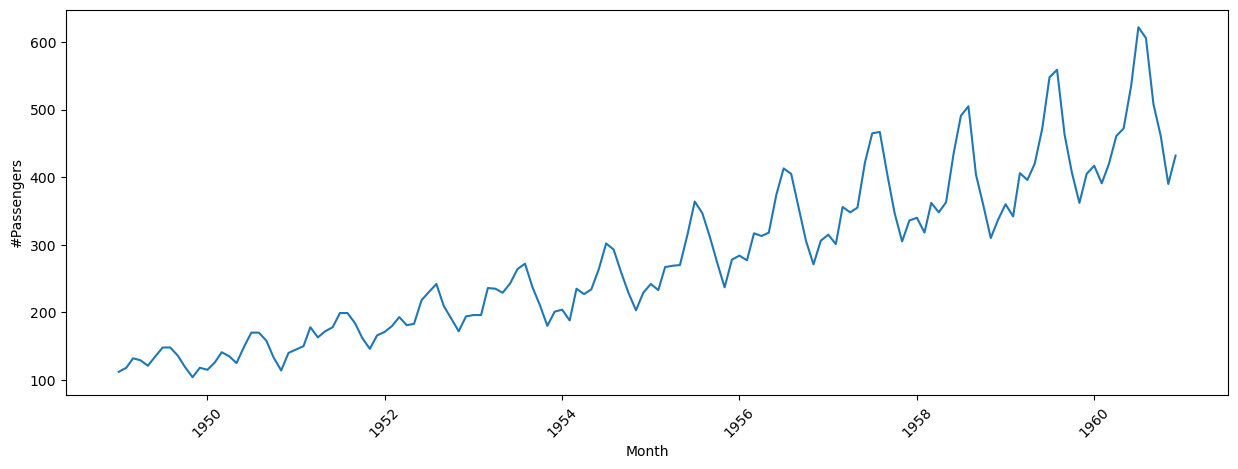

In [4]:
plot_lineplot_time_series(AirPassengers, "Month", "#Passengers")

# 1. Check Stationarity

The initial AirPassengers dataset is clearly not stationary, as the AD Fuller test has a p-value of 0.99.

However, if we decompose the signal between its trend and seasonal components, the seasonal trend is stationary. This provides us a good testbench to test how different algorithms perform on different waves.

In [5]:
result = adfuller(AirPassengers['#Passengers'])
print("ADF Statistic:", result[0])
print("p-value:", result[1])
print("Critical Values:", result[4])

ADF Statistic: 0.8153688792060597
p-value: 0.9918802434376411
Critical Values: {'1%': -3.4816817173418295, '5%': -2.8840418343195267, '10%': -2.578770059171598}


In [6]:
# Decompose the seasonal data
decomposition_result = seasonal_decompose(AirPassengers['#Passengers'], model='additive')

# Run AD Fuller only on seasonal
adf_result = adfuller(decomposition_result.seasonal)
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
print("Critical Values:", adf_result[4])

ADF Statistic: -4719265267567261.0
p-value: 0.0
Critical Values: {'1%': -3.4816817173418295, '5%': -2.8840418343195267, '10%': -2.578770059171598}


In [7]:
AirPassengers['Seasonal Passengers'] = decomposition_result.seasonal
AirPassengers.head(100)

,#Passengers,Seasonal Passengers
Month,,
1949-01-01,112,-24.748737
1949-02-01,118,-36.188131
1949-03-01,132,-2.241162
1949-04-01,129,-8.036616
1949-05-01,121,-4.506313
...,...,...
1956-12-01,306,-28.619949
1957-01-01,315,-24.748737
1957-02-01,301,-36.188131


# 1.1. ACF and PACF plots

These plots help us further understand the effect of the decomposition. The results are the expected:
- The raw # of passengers presents a ACF with a clear correlation at the yearly level, with significant components in the next month and a yearly level.
- The seasonal trend PACF shows that most seasonal components are correlated to each other (unsurprisingly). 

This information help us set the values for the ARIMA process.

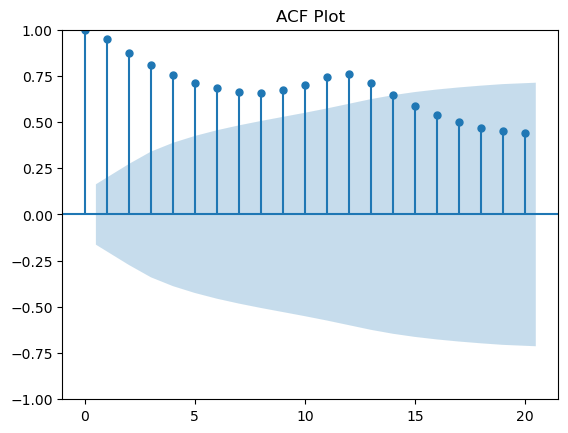

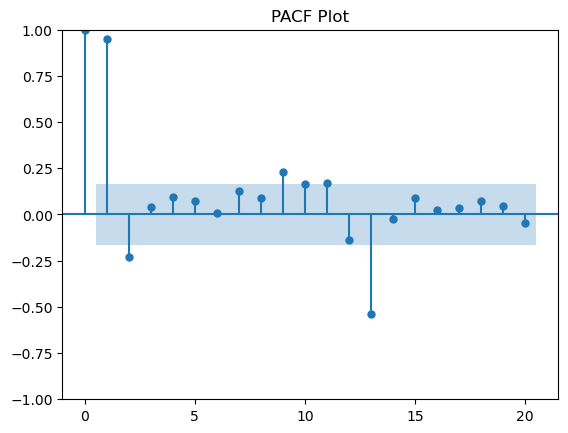

In [9]:
# Looking at the ACF and PACF
# plot ACF
plot_acf(AirPassengers['#Passengers'], lags=20)
plt.title("ACF Plot")
plt.show()

# plot PACF
plot_pacf(AirPassengers['#Passengers'], lags=20)
plt.title("PACF Plot")
plt.show()

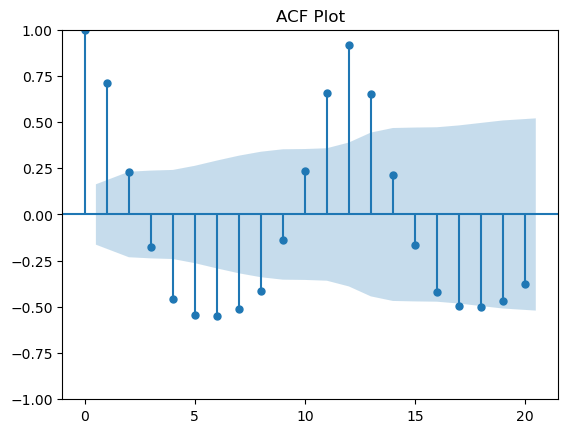

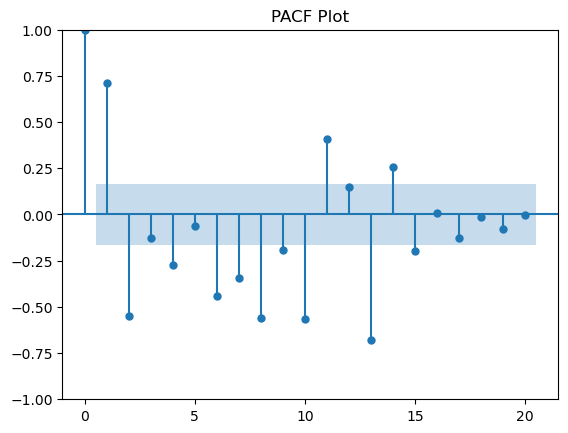

In [8]:
# Looking at the ACF and PACF
# plot ACF
plot_acf(AirPassengers['Seasonal Passengers'], lags=14)
plt.title("ACF Plot")
plt.show()

# plot PACF
plot_pacf(AirPassengers['Seasonal Passengers'], lags=14)
plt.title("PACF Plot")
plt.show()

# 2. Statistical Modelling
## 2.0. Preparing the data

In [37]:
# Raw data
data = AirPassengers['#Passengers']

# Split data into training and testing sets
train_size = int(len(data) * 0.8)
train_data, test_data = data[:train_size], data[train_size:]

# Seasonal data
data = AirPassengers['Seasonal Passengers']

# Split data into training and testing sets
train_size = int(len(data) * 0.8)
season_train_data, season_test_data = data[:train_size], data[train_size:]


## 2.1. Autoregression (AR)

Here, I apply an AR to both the raw data and the seasonal data.
- AR performs a suboptimal job in the raw data, due to the lack of stationarity
- AR matches perfectly the seasonal data - too good. This makes me think that this seasonality is generated using an AR.

In [42]:
def run_AR_analysis(train_data, test_data, p):

    # Train AR model
    ar_model = AutoReg(train_data, lags=p)
    ar_model_fit = ar_model.fit()

    # Make predictions on the testing data
    ar_predictions = ar_model_fit.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1, dynamic=False)

    # Calculate RMSE
    ar_rmse = np.sqrt(mean_squared_error(test_data, ar_predictions))

    # Visualize AR model performance
    plt.plot(test_data, label="Actual")
    plt.plot(ar_predictions, color="red", label="AR Predictions")
    plt.legend()
    plt.title(f"AR Model (p={p})\nRMSE: {ar_rmse:.2f}")
    plt.show()

/Users/miguelcachosoblechero/opt/anaconda3/envs/TimeSeries/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/miguelcachosoblechero/opt/anaconda3/envs/TimeSeries/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


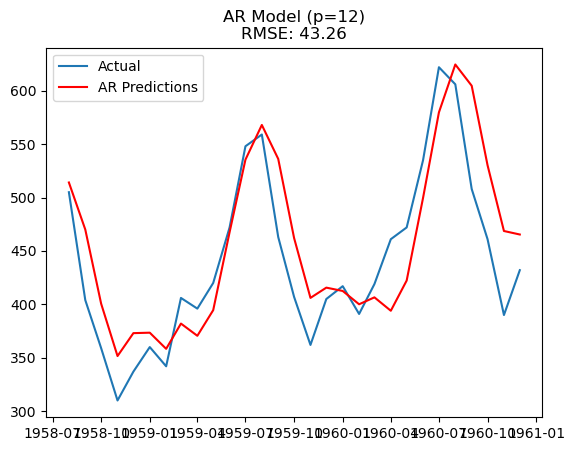

In [54]:
run_AR_analysis(train_data=train_data, test_data=test_data, p=12)

/Users/miguelcachosoblechero/opt/anaconda3/envs/TimeSeries/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/miguelcachosoblechero/opt/anaconda3/envs/TimeSeries/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


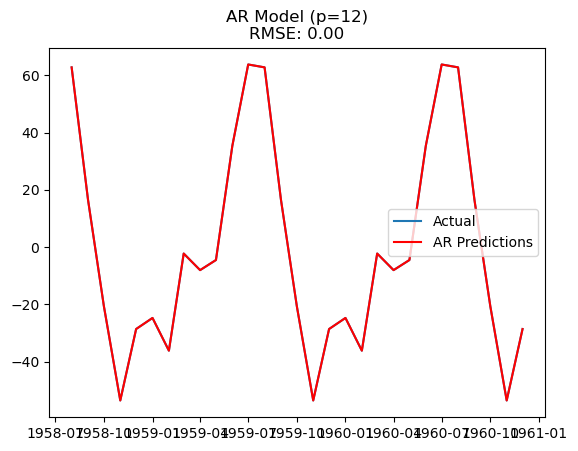

In [52]:
run_AR_analysis(train_data=season_train_data, test_data=season_test_data, p=12)

#